In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# ICPW Thematic report 2023

## Part A: Site selection

## 1. Get stations

In [3]:
# Get ICPW stations
xl_path = r"../../../all_icpw_sites_mar_2023.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="all_icpw_stns")
print(f"There are {len(stn_df)} stations in the ICPW project.")
display(stn_df.head())
nivapy.spatial.quickmap(stn_df, cluster=True, popup="station_code")

There are 577 stations in the ICPW project.


,station_id,station_code,nfc_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38810,AM_001,NaN,"Pambak river, 0.5 km above Khnkoyan village",40.839315,44.048911,NaN,Europe,Armenia,Armenia,Core
1,38811,AM_057,NaN,"Marmarik river, 0.5 km above Hankavan village",40.663605,44.466029,NaN,Europe,Armenia,Armenia,Core
2,38812,AM_080,NaN,"Vedi river, 0.5 km above Urtsadzor village",39.921174,44.819649,NaN,Europe,Armenia,Armenia,Core
3,38813,AM_083,NaN,"Arpa river, 0.5 km above Jermuk town",39.843045,45.686151,NaN,Europe,Armenia,Armenia,Core
4,38814,AM_089,NaN,"Meghri river, 0.5 km above Meghri town",38.915268,46.233703,NaN,Europe,Armenia,Armenia,Core


In [4]:
# Remove stations in Moldova as data seem unusable
stn_df = stn_df.query("country != 'Moldova'")

## 2. Get chemistry

### 2.1. Basic parameters

 * For now, assume LOD values are equal to the LOD.

In [5]:
# Specify time period of interest
st_dt = "1990-01-01"
end_dt = "2020-12-31"

# Specify RESA2 parameters of interest
params = ["SO4", "NO3-N", "NH4-N", "Cl", "Ca", "Mg", "Na", "K", "pH", "TOC"]

# Get available parameters
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df = par_df.query("parameter_name in @params")
par_df

130 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
17,11,Ca,mg/l
22,7,Cl,mg/l
49,12,K,mg/l
61,13,Mg,mg/l
66,49,NH4-N,µg/l N
67,5,NO3-N,µg/l N
68,14,Na,mg/l
90,8,SO4,mg/l
100,6,TOC,mg C/l
128,1,pH,None


In [6]:
# Get data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df,
    par_df,
    st_dt,
    end_dt,
    eng,
    lod_flags=False,
    drop_dups=True,
)

# Only consider samples within 1 m of surface
wc_df = wc_df.query("depth2 < 1")
del wc_df["depth1"], wc_df["depth2"]

wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,TOC_mg C/l,pH_
,,,,,,,,,,,,,,
0,100,623-603,Breidlivatnet,1990-10-07,0.35,0.9,0.12,0.17,NaN,26.0,0.73,2.9,4.72,4.72
1,100,623-603,Breidlivatnet,1991-09-29,0.40,0.8,0.10,0.15,NaN,27.0,0.80,3.1,3.56,4.89
2,100,623-603,Breidlivatnet,1992-10-10,0.49,0.9,0.15,0.16,NaN,6.0,0.82,2.8,5.90,4.78
3,100,623-603,Breidlivatnet,1993-10-14,0.36,0.7,0.13,0.10,NaN,28.0,0.64,2.2,6.60,4.95
4,100,623-603,Breidlivatnet,1994-10-01,0.37,0.7,0.11,0.13,NaN,66.0,0.60,2.2,5.70,4.79


### 2.2. Derived parameters

Using the "basic" parameters above:

 * Convert to microequivalents per litre where relevant
 
 * Calculate (Ca + Mg) in ueq/l
 
 * Calculate [H+] from pH
 
 * Calculate SAA (sum of acid anions) as $(Cl + SO_4 + NO_3)$ (all expressed in ueq/l)
 
 * Calculate ANC as $(Ca + Mg + Na + K + NH_4) - (Cl + SO_4 + NO_3)$ (all expressed in ueq/l)
 
 * Calculate organic anions using the model of [Hruška et al. (2003)](https://doi.org/10.1021/es0201552)
 
 * Calculate bicarbonate from the ion balance as $ANC + H - OrgAnions$ (all expressed in ueq/l)
 
See the issue [here](https://github.com/JamesSample/icpw2/issues/3) for further details.

In [7]:
# Convert to ueq/l
ueq_cols = [
    "SO4_mg/l",
    "NO3-N_µg/l N",
    "NH4-N_µg/l N",
    "Cl_mg/l",
    "Ca_mg/l",
    "Mg_mg/l",
    "Na_mg/l",
    "K_mg/l",
]
for col in ueq_cols:
    wc_df = utils.convert_to_microequivalents(wc_df, col)

# Ca + Mg
wc_df["CaMg_µeq/l"] = wc_df["Ca_µeq/l"] + wc_df["Mg_µeq/l"]

# H+ from pH
wc_df["H_µeq/l"] = 1e6 * 10 ** -wc_df["pH_"]

# Calculate SAA
wc_df["SAA_µeq/l"] = wc_df["Cl_µeq/l"] + wc_df["SO4_µeq/l"] + wc_df["NO3-N_µeq/l"]

# Calculate ANC
wc_df = utils.calculate_anc(wc_df, anc_oaa=False)

# Organic anions
wc_df = utils.calculate_organic_anions(wc_df, site_density=17.4)

# HCO3
wc_df = utils.calculate_bicarbonate(wc_df)

In [8]:
# Save for speed later
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df.to_csv(csv_path, index=False, encoding="utf-8")

## 3. Aggregate to annual medians

In [9]:
# Read saved data
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")
wc_df.head()

,station_id,station_code,station_name,sample_date,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,...,Ca_µeq/l,Mg_µeq/l,Na_µeq/l,K_µeq/l,CaMg_µeq/l,H_µeq/l,SAA_µeq/l,ANC_µeq/l,OrgAnions_µeq/l,HCO3_µeq/l
0,100,623-603,Breidlivatnet,1990-10-07,0.35,0.9,0.12,0.17,NaN,26.0,...,17.465070,13.984863,31.753212,3.068897,31.449933,19.054607,87.620789,-21.348747,45.549655,0.0
1,100,623-603,Breidlivatnet,1991-09-29,0.40,0.8,0.10,0.15,NaN,27.0,...,19.960080,12.339585,34.798041,2.557414,32.299665,12.882496,89.035577,-19.380456,36.238083,0.0
2,100,623-603,Breidlivatnet,1992-10-10,0.49,0.9,0.15,0.16,NaN,6.0,...,24.451098,13.162224,35.667992,3.836121,37.613322,16.595869,84.110220,-6.992785,58.093289,0.0
3,100,623-603,Breidlivatnet,1993-10-14,0.36,0.7,0.13,0.10,NaN,28.0,...,17.964072,8.226390,27.838433,3.324638,26.190462,11.220185,67.548393,-10.194860,68.284884,0.0
4,100,623-603,Breidlivatnet,1994-10-01,0.37,0.7,0.11,0.13,NaN,66.0,...,18.463074,10.694307,26.098531,2.813155,29.157381,16.218101,70.262679,-12.193611,56.304668,0.0


In [10]:
# Annual medians by station
wc_df["year"] = wc_df["sample_date"].dt.year
ann_df = wc_df.groupby(["station_id", "year"]).median().reset_index()
ann_df.head()

,station_id,year,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,...,Ca_µeq/l,Mg_µeq/l,Na_µeq/l,K_µeq/l,CaMg_µeq/l,H_µeq/l,SAA_µeq/l,ANC_µeq/l,OrgAnions_µeq/l,HCO3_µeq/l
0,100,1990,0.35,0.9,0.12,0.17,NaN,26.0,0.73,2.9,...,17.465070,13.984863,31.753212,3.068897,31.449933,19.054607,87.620789,-21.348747,45.549655,0.0
1,100,1991,0.40,0.8,0.10,0.15,NaN,27.0,0.80,3.1,...,19.960080,12.339585,34.798041,2.557414,32.299665,12.882496,89.035577,-19.380456,36.238083,0.0
2,100,1992,0.49,0.9,0.15,0.16,NaN,6.0,0.82,2.8,...,24.451098,13.162224,35.667992,3.836121,37.613322,16.595869,84.110220,-6.992785,58.093289,0.0
3,100,1993,0.36,0.7,0.13,0.10,NaN,28.0,0.64,2.2,...,17.964072,8.226390,27.838433,3.324638,26.190462,11.220185,67.548393,-10.194860,68.284884,0.0
4,100,1994,0.37,0.7,0.11,0.13,NaN,66.0,0.60,2.2,...,18.463074,10.694307,26.098531,2.813155,29.157381,16.218101,70.262679,-12.193611,56.304668,0.0


## 4. Site selection

In [11]:
# Pars to consider
df = ann_df.copy()
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]
df = df[["station_id", "year"] + pars]

# Melt to long format
df = pd.melt(df, id_vars=["station_id", "year"])
df.dropna(how="any", inplace=True)
df.head()

,station_id,year,variable,value
0,100,1990,SO4_µeq/l,60.377924
1,100,1991,SO4_µeq/l,64.541919
2,100,1992,SO4_µeq/l,58.295927
3,100,1993,SO4_µeq/l,45.803942
4,100,1994,SO4_µeq/l,45.803942


In [12]:
# Define selection criteria
n_start_thresh = 1  # Number of annual values in first 5 years
n_end_thresh = 1  # Number of annual values in last 5 years
prop_thresh = 0.65  # Proportion of total years with data
periods = ((1990, 2020), (1990, 2004), (1998, 2012), (2008, 2020))

# Dict for results
inc_dict = {
    "station_id": [],
    "variable": [],
    "period": [],
    "include": [],
}

# Loop over time series
for stn_id in df["station_id"].unique():
    # Loop over variables
    for par in df["variable"].unique():
        # Get data
        stn_par_df = df.query("(station_id == @stn_id) and (variable == @par)")
        stn_par_df.set_index("year", inplace=True)
        del stn_par_df["station_id"], stn_par_df["variable"]

        for period in periods:
            st_yr, end_yr = period
            years = range(st_yr, end_yr + 1)
            n_yrs = len(years)
            yrs_thresh = round(n_yrs * prop_thresh)
            years_df = pd.DataFrame(index=years)

            # Join by year (=> annual series with no gaps)
            stn_par_yr_df = years_df.join(stn_par_df)

            if pd.isna(stn_par_yr_df["value"]).all().all():
                # Not suitable
                inc_dict["station_id"].append(stn_id)
                inc_dict["variable"].append(par)
                inc_dict["period"].append(f"{st_yr}-{end_yr}")
                inc_dict["include"].append(0)

            else:
                n_start = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index < (st_yr + 5)]["value"]
                ).sum()
                n_end = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index > (end_yr - 5)]["value"]
                ).sum()
                non_missing = pd.notnull(stn_par_yr_df["value"]).sum()

                if (
                    (n_start >= n_start_thresh)
                    and (n_end >= n_end_thresh)
                    and (non_missing >= yrs_thresh)
                ):
                    # Include
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["period"].append(f"{st_yr}-{end_yr}")
                    inc_dict["include"].append(1)

                else:
                    # Not suitable
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["period"].append(f"{st_yr}-{end_yr}")
                    inc_dict["include"].append(0)

# Build df
inc_df = pd.DataFrame(inc_dict)

# # Calculate bool cols describing presence of *combinations* of params
# # Unstack to 'wide'
# inc_df.set_index(["station_id", "variable", "st_yr"], inplace=True)
# inc_df = inc_df.unstack("variable")
# inc_df.columns = inc_df.columns.get_level_values(1)
# inc_df.reset_index(inplace=True)

# # Are all params present?
# inc_df["TOC_TOTN_NO3"] = (
#     (inc_df["TOC_mg C/l"] + inc_df["TOTN_µg/l N"] + inc_df["NO3-N_µg/l N"]) == 3
# ).astype(int)

# inc_df["TOC_TOTN_NO3_NH4"] = (
#     (
#         inc_df["TOC_mg C/l"]
#         + inc_df["TOTN_µg/l N"]
#         + inc_df["NO3-N_µg/l N"]
#         + inc_df["NH4-N_µg/l N"]
#     )
#     == 4
# ).astype(int)

# # Melt back to 'long'
# inc_df = inc_df.melt(id_vars=["station_id", "st_yr"], value_name="include",)

# # Sum number of stations
# nstns_df = inc_df.groupby(["variable", "st_yr"]).sum().reset_index()
# nstns_df.rename({"include": "n_stns"}, inplace=True, axis="columns")
# del nstns_df["station_id"]

In [13]:
# Unstack to 'wide'
inc_df.set_index(["station_id", "variable", "period"], inplace=True)
inc_df = inc_df.unstack("variable")
inc_df.columns = inc_df.columns.get_level_values(1)
inc_df.reset_index(inplace=True)

# Join station details
inc_df = pd.merge(
    inc_df,
    stn_df[["station_id", "station_code", "station_name", "country"]],
    how="left",
    on="station_id",
)

inc_df.to_csv("./data/selection_criteria_by_station-par-period.csv", index=False)

## 5. Annual distributions by country

For each parameter.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


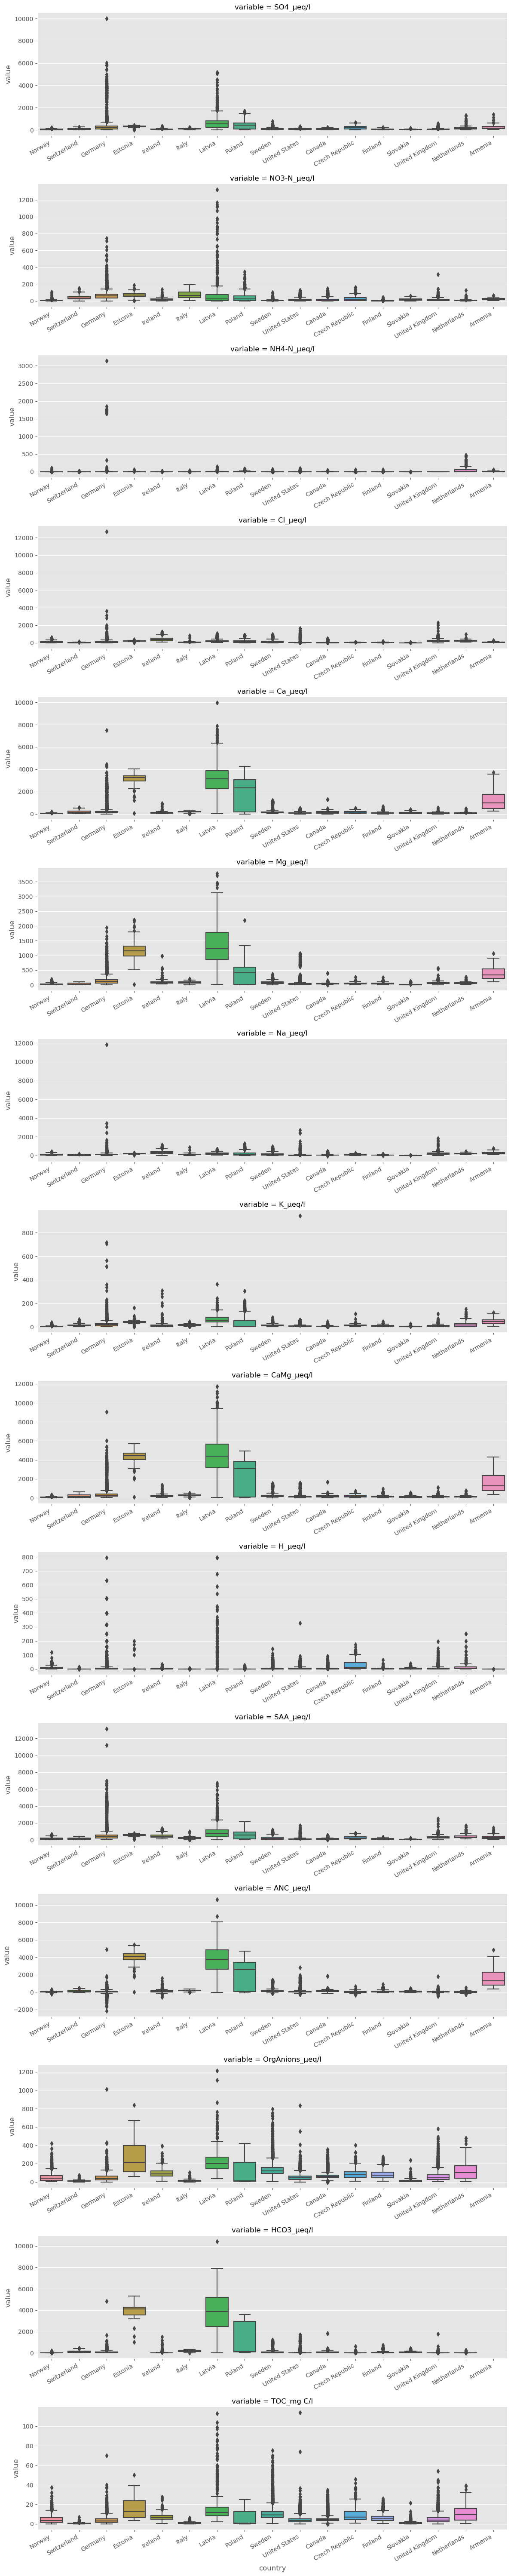

In [14]:
# Join country attribute
df = pd.merge(wc_df, stn_df[["station_id", "country"]], how="left", on="station_id")

# Pars to plot
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]

# Reshape
df = df[["country"] + pars]
df = df.melt(id_vars=["country"])

# Plot
g = sn.catplot(
    data=df,
    x="country",
    y="value",
    row="variable",
    kind="box",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3,
)
g.set_xticklabels(rotation=30, ha="right")
plt.tight_layout()